In [1]:
import os 
import librosa
import math 
import json
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
dataset_path = r'./input/notes_v2/'
json_path = r'data.json'
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [139]:
def save_mfcc(dataset_path: str, json_path: str, n_mfcc=13, 
              n_fft=2048, hop_length=512, num_segments=5):
    
    data = {
        'mapping': [],
        'mfcc': [],
        'labels': []
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)
    expected_vects_ps = math.ceil(samples_ps / hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_comp = dirpath.split('/')
            semantic_label = dirpath_comp[-1]
            data['mapping'].append(semantic_label)
            print(f'Processing: {semantic_label}')
            
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                print(file_path, dirpath)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                
                for s in range(num_segments):
                    mfcc = librosa.feature.mfcc(signal,
                                                sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
                    
                    mfcc = mfcc.T
                    
                    
                    
                    data['mfcc'].append(np.array(np.array(mfcc.tolist())))
                    data['labels'].append(i-1)
                    print(f'{file_path}, segment: {s + 1}')
                        
    return data

In [140]:
from IPython.display import clear_output

In [141]:
data = save_mfcc(dataset_path, json_path, num_segments=10)
clear_output()

./input/notes_v2/B/B0.wav


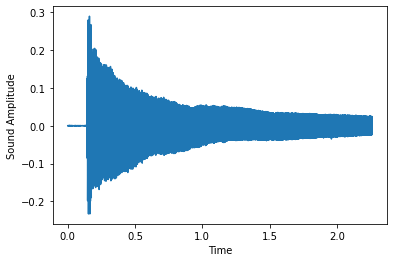

./input/notes_v2/B/B1.wav


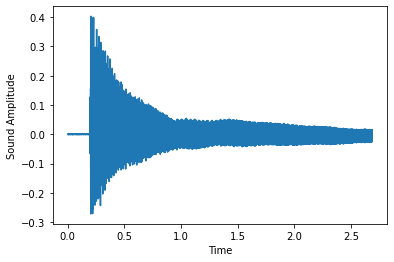

In [142]:
filepath = f'./input/notes_v2/B/B'

for i in range(2):
    print(filepath + str(i) + '.wav')
    audio, sfreq = librosa.load(filepath + str(i+1) + '.wav')
    time = np.arange(0, len(audio)) / sfreq
    plt.plot(time, audio)
    plt.xlabel("Time")
    plt.ylabel('Sound Amplitude')
    plt.show()

In [143]:
def load_data(data):
        
    inputs = np.array(data['mfcc'])
    targets = np.array(data['labels'])
    
    return inputs, targets
        

In [144]:
inputs, targets = load_data(data=data)

C:\Users\GODOVO~1\AppData\Local\Temp/ipykernel_7324/2963783439.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inputs = np.array(data['mfcc'])


In [152]:
inputs.shape

(720,)

In [153]:
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(504,) (504,)


# CNN

In [154]:
def prepare_dataset(test_size, validation_size):
    X, y = load_data(data)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)
    
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [155]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

C:\Users\GODOVO~1\AppData\Local\Temp/ipykernel_7324/2963783439.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inputs = np.array(data['mfcc'])


In [156]:
X_train.shape

(432, 1)

In [157]:
input_shape = (X_train.shape[0], X_train.shape[1], 1)
input_shape

(432, 1, 1)

In [158]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
import tensorflow.keras as keras

In [159]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D((3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D((3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(16, (1,1), activation='relu'))
model.add(MaxPool2D((1,1), strides=(2,2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.summary()


ValueError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_3/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_3/Conv2D/ReadVariableOp)' with input shapes: [?,432,1,1], [3,3,1,64].

In [114]:
adam = optimizers.Adam(learning_rate=1e-4)

In [115]:
model.compile(optimizer=adam, 
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, 
                 validation_data=(X_val, y_val),
                 epochs=40,
                 batch_size=32)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).